## Dependencias 

In [24]:
import numpy as np 
import pandas as pd 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from functools import reduce 
pd.set_option('display.max_columns',None)

## Lectura de datos 

In [3]:
data = pd.read_csv('../../data/heart_disease.tab',delimiter='\t')
data.shape

(303, 14)

In [4]:
data.sample(5)

,diameter narrowing,age,gender,chest pain,rest SBP,cholesterol,fasting blood sugar > 120,rest ECG,max HR,exerc ind ang,ST by exercise,slope peak exc ST,major vessels colored,thal
232,1,49,male,non-anginal,118,149,0,left vent hypertrophy,126,0,0.8,upsloping,3.0,normal
168,1,35,male,asymptomatic,126,282,0,left vent hypertrophy,156,1,0.0,upsloping,0.0,reversable defect
32,1,64,male,non-anginal,140,335,0,normal,158,0,0.0,upsloping,0.0,normal
299,1,68,male,asymptomatic,144,193,1,normal,141,0,3.4,flat,2.0,reversable defect
106,1,59,male,asymptomatic,140,177,0,normal,162,1,0.0,upsloping,1.0,reversable defect


## Clasificación de variables 

In [5]:
varc = ['age','rest SBP','cholesterol','max HR','ST by exercise','major vessels colored']
vard = [ 'gender', 'chest pain',  'fasting blood sugar > 120', 'rest ECG', 'exerc ind ang',  'slope peak exc ST','thal']
vart = ['diameter narrowing']

In [6]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')
for v in vard:
    data[v] =data[v].fillna('MISSING')

## Partición 

In [7]:
train,valid = train_test_split(data,test_size=0.2)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((242, 14), (61, 14))

### Matriz de predictoras $\mathcal{X}$

In [8]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(train[vard])
varoh = list(oh.get_feature_names_out())
varoh

['gender_male',
 'chest pain_asymptomatic',
 'chest pain_atypical ang',
 'chest pain_non-anginal',
 'chest pain_typical ang',
 'fasting blood sugar > 120_1',
 'rest ECG_ST-T abnormal',
 'rest ECG_left vent hypertrophy',
 'rest ECG_normal',
 'exerc ind ang_1',
 'slope peak exc ST_downsloping',
 'slope peak exc ST_flat',
 'slope peak exc ST_upsloping',
 'thal_MISSING',
 'thal_fixed defect',
 'thal_normal',
 'thal_reversable defect']

In [9]:
X = train[varc].copy()
X[varoh] = oh.transform(train[vard])
X.head()
im = SimpleImputer(strategy='median')
im.fit(X)
X = pd.DataFrame(im.transform(X),columns=X.columns)

### Vector respuesta $\vec{y}$

In [10]:
y = train[vart[0]]
y.head()

0    1
1    1
2    1
3    1
4    1
Name: diameter narrowing, dtype: int64

## Aprendizaje 

In [11]:
var = varc+varoh

### Predictoras más fuertes 

In [12]:
sk = SelectKBest(k=len(var))
sk.fit(X,y)

,score_func,<function f_c...t 0x115e1c900>
,k,23


<Axes: >

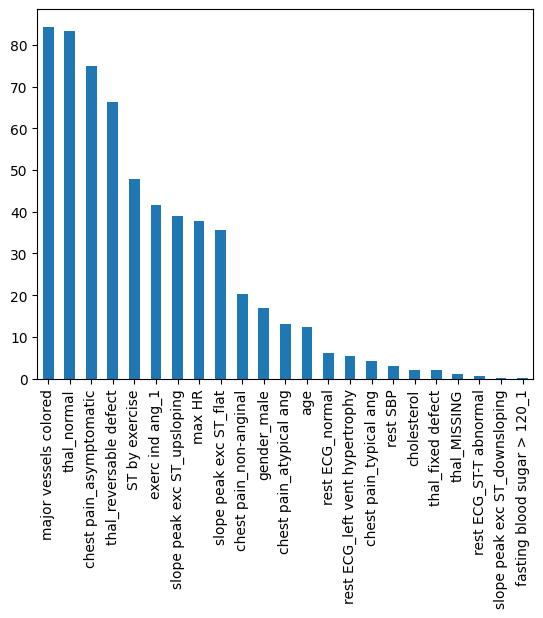

In [13]:
pd.Series(dict(zip(var,sk.scores_))).sort_values(ascending=False).plot(kind='bar')

In [14]:
k = 5 
sk = SelectKBest(k=k)
sk.fit(X,y)

,score_func,<function f_c...t 0x115e1c900>
,k,5


In [15]:
best = [v for v,s in zip(var,sk.get_support()) if s]
best

['ST by exercise',
 'major vessels colored',
 'chest pain_asymptomatic',
 'thal_normal',
 'thal_reversable defect']

In [16]:
X = train[varc].copy()
X[varoh] = oh.transform(train[vard])
X.head()
im = SimpleImputer(strategy='median')
im.fit(X[best])
X = pd.DataFrame(im.transform(X[best]),columns=best)

### Híper-parametrización

In [17]:
hparam_grid = {
    'hidden_layer_sizes': [(a,b,c,) for a in range(2,10) for b in range(2,10) for c in range(2,10)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-5, -1, 5),
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 500, 1000],
    'batch_size': [16, 32, 64]
}


In [18]:
reduce(lambda x,y: x*y, map(len,hparam_grid.values()))

276480

In [22]:
ann = MLPClassifier()

In [25]:
grid = RandomizedSearchCV(
    estimator=ann,
    param_distributions=hparam_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=True,
    cv=5,
    n_iter= 50 
)

In [26]:
grid.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gus/Library/Mobile Docum

,estimator,MLPClassifier()
,param_distributions,"{'activation': ['relu', 'tanh', ...], 'alpha': array([1.e-05...e-02, 1.e-01]), 'batch_size': [16, 32, ...], 'hidden_layer_sizes': [(2, ...), (2, ...), ...], ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [27]:
grid.best_score_

np.float64(0.9259259259259259)

In [28]:
ann = grid.best_estimator_
ann

,hidden_layer_sizes,"(9, ...)"
,activation,'tanh'
,solver,'sgd'
,alpha,np.float64(0.0001)
,batch_size,32
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,None


### Aprendizaje final $\vec{y} = f (\mathcal{X};\theta)$  (Ahora si vamos a aprender el modelo)

In [29]:
ann.fit(X,y)

,hidden_layer_sizes,"(9, ...)"
,activation,'tanh'
,solver,'sgd'
,alpha,np.float64(0.0001)
,batch_size,32
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,None


#### $\vec{\theta},\theta_0$

In [30]:
[layer.shape for layer in ann.coefs_]

[(5, 9), (9, 7), (7, 6), (6, 1)]

In [31]:
ann.feature_names_in_

array(['ST by exercise', 'major vessels colored',
       'chest pain_asymptomatic', 'thal_normal', 'thal_reversable defect'],
      dtype=object)

## Generalización del modelo (qué tan bien se comporta en datos que nunca vió, es importante aplicar TODAS las transfromaciones previas)

In [32]:
Xv = valid[varc].copy()
Xv[varoh] = oh.transform(valid[vard])
Xv = pd.DataFrame(im.transform(Xv[best]),columns=best)

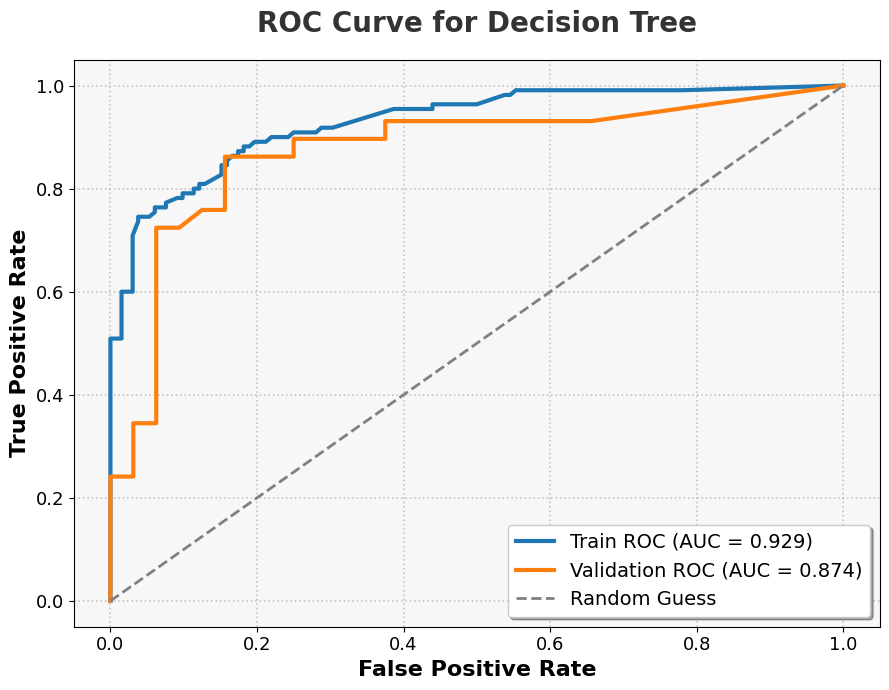

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Training ROC and AUC
y_train_proba = ann.predict_proba(X)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y, y_train_proba)
auc_train = auc(fpr_train, tpr_train)

# Validation ROC and AUC
y_valid = valid['diameter narrowing']
y_valid_proba = ann.predict_proba(Xv)[:, 1]
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
auc_valid = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(9, 7))
plt.plot(fpr_train, tpr_train, color='#1f77b4', lw=3, label=f'Train ROC (AUC = {auc_train:.3f})')
plt.plot(fpr_valid, tpr_valid, color='#ff7f0e', lw=3, label=f'Validation ROC (AUC = {auc_valid:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')

plt.title('ROC Curve for Decision Tree', fontsize=20, fontweight='bold', color='#333333', pad=20)
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.legend(fontsize=14, loc='lower right', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', linewidth=1.2, alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.show()

## Uso del modelo 

In [35]:

# Generate predicted probabilities for both training and validation sets using the logistic regression model
y_train_proba = ann.predict_proba(X)[:, 1]
y_valid_proba = ann.predict_proba(Xv)[:, 1]

# Define probability bins from 0 to 1 in steps of 0.2
prob_bins = np.arange(0, 1.1, 0.2)  # [0. , 0.2, 0.4, ..., 1.0]
prob_labels = [f"{prob_bins[i]:.1f}-{prob_bins[i+1]:.1f}" for i in range(len(prob_bins)-1)]

# Bin the probabilities
train_prob_range = pd.cut(y_train_proba, bins=prob_bins, labels=prob_labels, include_lowest=True)
valid_prob_range = pd.cut(y_valid_proba, bins=prob_bins, labels=prob_labels, include_lowest=True)

# Build DataFrames for train and valid
df_train_probs = pd.DataFrame({
    'target': y.values,
    'probability': y_train_proba,
    'prob_range': train_prob_range,
    'sample': 'train'
})

df_valid_probs = pd.DataFrame({
    'target': y_valid.values,
    'probability': y_valid_proba,
    'prob_range': valid_prob_range,
    'sample': 'valid'
})

# Concatenate into a single DataFrame
df_probs = pd.concat([df_train_probs, df_valid_probs], ignore_index=True)

# Show the first few rows
df_probs.head()



,target,probability,prob_range,sample
0,1,0.988178,0.8-1.0,train
1,1,0.986001,0.8-1.0,train
2,1,0.855200,0.8-1.0,train
3,1,0.959240,0.8-1.0,train
4,1,0.951392,0.8-1.0,train


In [36]:
df_probs['prob_range'].value_counts()

prob_range
0.0-0.2    108
0.8-1.0     94
0.2-0.4     51
0.4-0.6     28
0.6-0.8     22
Name: count, dtype: int64

In [37]:
df_probs.drop('probability',axis=1).assign(n=1).groupby(['target','prob_range','sample']).count().to_clipboard()

/var/folders/b2/142kycp96wdg69k6pkw9_vf00000gp/T/ipykernel_6226/2932223669.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_probs.drop('probability',axis=1).assign(n=1).groupby(['target','prob_range','sample']).count().to_clipboard()


In [72]:
!python -V

Python 3.13.7
